In [1]:
import torch
torch.backends.cudnn.benchmark=True  # 加速

In [2]:
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision import models
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torchinfo import summary
# 輔助工具
import os
import matplotlib.pyplot as plt 
from time import time 
import datetime
import random
import numpy as np
import pandas as pd
import gc  # garbage collector 垃圾回收

# 實用函數定義

In [85]:
class EarlyStopping():  
    def __init__(self, patience=5, tolerance=0.0005):
        """
        判斷迭代是否需要停止
        當連續patience輪迭帶所施予歷史最低損失之間的差值小於tolerance時
        就觸發提前停止
        """
        self.patience = patience
        self.tol = tolerance 
        self.counter = 0  # 計數器
        self.lowest_loss = None  # 歷史最低損失
        self.early_stop = False  # True: 提前停止，False: 不要提前停止
    
    def __call__(self, val_loss):
        if self.lowest_loss == None:
            self.lowest_loss = val_loss
        elif self.lowest_loss - val_loss >= self.tol:
            self.lowest_loss = val_loss
            self.counter = 0
        elif self.lowest_loss - val_loss < self.tol:  # 未持續下降
            self.counter += 1
            print("\t NOTICE: Early stopping counter {} of {}".format(self.counter, self.patience))
            if self.counter >= self.patience:
                print('\t NOTICE: Early Stopping Actived')
                self.early_stop = True
        return self.early_stop

In [86]:
def plotloss(trainloss, testloss):
    plt.figure(figsize=(10, 7))
    plt.plot(trainloss, color="red", label="TrainLoss")
    plt.plot(testloss, color="orange", label="TestLoss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [87]:
def plotsample(data, num_pics=5):
    fig, axs = plt.subplots(1, num_pics, figsize=(10, 10))
    nums = np.random.choice(len(data) - 1, num_pics)
    for idx, num in enumerate(nums):
        # npimg = torchvision.utils.make_grid(data[num][0]).numpy()
        npimg = data[num][0].numpy()  # img: 3 * 28 * 28
        nplabel = data[num][1]  # label
        axs[idx].imshow(np.transpose(npimg, (1, 2, 0)))
        axs[idx].set_title(nplabel)
        axs[idx].axis("off")

In [88]:
def TrainOnce(net, criterion, optimizer, x, y):
    """
    模型訓練一次
    net: 實例化後的模型架構
    criterion: 損失函數
    optimizer: 優化算法
    x: 這一個batch中所有的樣本
    y: 這一個batch中所有的樣本標籤
    """
    net.train()
    sigma = net.forward(x)  # ypred
    loss = criterion(sigma, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad(set_to_none=True) 
    yhat = torch.max(sigma, 1)[1]  # CrossEntropy已經過了一次Softmax
    correct = torch.sum(yhat == y)
    return correct, loss

In [89]:
def TestOnce(net, criterion, x, y):
    """
    模型測試一次
    net: 訓練後的模型架構
    criterion: 損失函數
    optimizer: 優化算法
    x: 這一個batch中所有的樣本
    y: 這一個batch中所有的樣本標籤
    """
    net.eval()
    with torch.no_grad():
        sigma = net.forward(x)
        loss = criterion(sigma, y)
        yhat = torch.max(sigma, 1)[1]
        correct = torch.sum(yhat == y)
    return correct, loss

In [90]:
def fit_test(net, traindata, testdata, criterion, optimizer, epochs, modelname, PATH, 
             scheduler_lr_lambda=None, patience=5, tolerance=10**(-5), device=torch.device("cuda")):
    """
    訓練 測試 監控 保存
    net: 實例化後的模型架構
    batchdata： 使用Dataloader分割後的訓練數據
    testdata： 使用Dataloader分割後的測試數據
    criterion： 損失函數
    optimizer: 優化算法
    epochs： 總epoch數
    tolerance, patience ： 提前停止時測試集上losss下降的閥值，連續patience次loss下降不超過tolerance就停止
    modelname： 存檔的模型檔名
    PATH： 模型保存路徑
    scheduler_lr_lambda: 學習率調整策略(lambd匿名函數)
    speedup: 是否使用GPU加速
    """
    
    TrainDataPerEpoch = len(traindata.dataset)  # 一個完整epoch的總訓練樣本數 
    Allsamples = TrainDataPerEpoch * epochs     # epochs個epoch的總訓練樣本數
    TestDataPerEpoch = len(testdata.dataset)    # 一個完整epoch的總測試樣本數 
    trainedsamples = 0
    trainlosslist = []
    testlosslist = []
    early_stopping = EarlyStopping(patience=patience, tolerance=tolerance)
    highestacc = 0
    if scheduler_lr_lambda:
        scheduler = lr_scheduler.LambdaLR(optimizer, scheduler_lr_lambda) 
        
    net, criterion = net.to(device, non_blocking=True), criterion.to(device, non_blocking=True)
    for epoch in range(1, epochs + 1):
        correct_train = 0
        loss_train = 0
        for idx, (x, y) in enumerate(traindata):
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            correct, loss = TrainOnce(net, criterion, optimizer, x, y.view(-1))
            
            trainedsamples += x.shape[0]  # 已訓練多少樣本
            loss_train += loss  # 總loss
            correct_train += correct  # 總正確次數
            
            if (idx + 1) % 125 == 0:
                print('Epoch{}:[{}/{}({:.0f}%)]'.format(epoch  # 訓練到第幾個epoch
                                                       ,trainedsamples  # 已訓練多少樣本
                                                       ,Allsamples  # 總需訓練的樣本數
                                                       ,100 * trainedsamples / Allsamples))  # 已訓練的百分比
        if scheduler_lr_lambda:
            scheduler.step()
        TrainAccThisEpoch = float(correct_train * 100) / TrainDataPerEpoch  # 怕數值太小不好觀察所以*100
        TrainLossThisEpoch = float(loss_train * 100) / TrainDataPerEpoch
        trainlosslist.append(TrainLossThisEpoch)
        
        # 清理GPU内存
        del x, y, correct, loss, correct_train, loss_train
        gc.collect()
        torch.cuda.empty_cache()
        
        # Test mode
        loss_test = 0
        correct_test = 0
        for x, y in testdata:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            
            correct, loss = TestOnce(net, criterion, x, y.view(-1))
            loss_test += loss
            correct_test += correct

        TestAccThisEpoch = float(correct_test * 100) / TestDataPerEpoch
        TestLossThisEpoch = float(loss_test * 100) / TestDataPerEpoch
        testlosslist.append(TestLossThisEpoch)
        
        # 清理GPU內存
        del x, y, correct, loss, correct_test, loss_test
        gc.collect()
        torch.cuda.empty_cache()

        print("\t Train Loss:{:.6f}, Test Loss:{:.6f}, Train Acc:{:.3f}%, Test Acc:{:.3f}%".format(TrainLossThisEpoch
                                                                                                  ,TestLossThisEpoch
                                                                                                  ,TrainAccThisEpoch
                                                                                                  ,TestAccThisEpoch))
        
        # 測試集準確率出現新高，保存模型
        if highestacc < TestAccThisEpoch:
            highestacc = TestAccThisEpoch
            torch.save(net.state_dict(), os.path.join(PATH, modelname + ".pt"))
            print("\t Weight Saved")
        
        #提前停止
        if early_stopping(TestLossThisEpoch):
            break
            
    print("Complete")
    return trainlosslist, testlosslist

# 模型建立

In [9]:
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 參考layer1刪除池化層
        # 參考ResNet設計bias設置False
        self.block1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  
                                   ,resnet18_.bn1
                                   ,resnet18_.relu) 
        
        # 小數據集先以加寬度為主非深度
        self.block2 = resnet18_.layer2 # 2個殘差單元
        self.block3 = resnet18_.layer3 # 2個殘差單元
        self.avgpool = resnet18_.avgpool
        self.fc = nn.Linear(in_features=256, out_features=10, bias=True)
    
    def forward(self,x):
        x = self.block3(self.block2(self.block1(x)))
        x = self.avgpool(x)
        x = x.view(-1, 256)
        x = self.fc(x)
        return x

In [12]:
resnet18_

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
resnet18_ = models.resnet18()
net_ = MyResNet()
summary(net_, input_size=(10, 3, 28, 28), depth=4, device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
MyResNet                                 [10, 10]                  --
├─Sequential: 1-1                        [10, 64, 28, 28]          --
│    └─Conv2d: 2-1                       [10, 64, 28, 28]          1,728
│    └─BatchNorm2d: 2-2                  [10, 64, 28, 28]          128
│    └─ReLU: 2-3                         [10, 64, 28, 28]          --
├─Sequential: 1-2                        [10, 128, 14, 14]         --
│    └─BasicBlock: 2-4                   [10, 128, 14, 14]         --
│    │    └─Conv2d: 3-1                  [10, 128, 14, 14]         73,728
│    │    └─BatchNorm2d: 3-2             [10, 128, 14, 14]         256
│    │    └─ReLU: 3-3                    [10, 128, 14, 14]         --
│    │    └─Conv2d: 3-4                  [10, 128, 14, 14]         147,456
│    │    └─BatchNorm2d: 3-5             [10, 128, 14, 14]         256
│    │    └─Sequential: 3-6              [10, 128, 14, 14]         --


## 再加深網路

In [11]:
class MyResNet2(nn.Module):
    def __init__(self):
        super().__init__()
        # 參考layer1刪除池化層
        # 參考ResNet設計bias設置False
        self.block1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  
                                   ,resnet18_.bn1
                                   ,resnet18_.relu) 
        
        # 小數據集先以加寬度為主非深度
        self.block2 = resnet18_.layer2 # 2個殘差單元
        self.block3 = resnet18_.layer3 # 2個殘差單元
        self.block4 = resnet18_.layer4 # 多加一層增加學習能力，2個殘差單元
        self.avgpool = resnet18_.avgpool
        self.fc = nn.Linear(in_features=512, out_features=10, bias=True)
    
    def forward(self,x):
        x = self.block4(self.block3(self.block2(self.block1(x))))
        x = self.avgpool(x)
        x = x.view(-1, 512)
        x = self.fc(x)
        return x

In [12]:
resnet18_ = models.resnet18()
net_ = MyResNet2()
summary(net_, input_size=(10, 3, 28, 28), depth=2, device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
MyResNet2                                [10, 10]                  --
├─Sequential: 1-1                        [10, 64, 28, 28]          --
│    └─Conv2d: 2-1                       [10, 64, 28, 28]          1,728
│    └─BatchNorm2d: 2-2                  [10, 64, 28, 28]          128
│    └─ReLU: 2-3                         [10, 64, 28, 28]          --
├─Sequential: 1-2                        [10, 128, 14, 14]         --
│    └─BasicBlock: 2-4                   [10, 128, 14, 14]         230,144
│    └─BasicBlock: 2-5                   [10, 128, 14, 14]         295,424
├─Sequential: 1-3                        [10, 256, 7, 7]           --
│    └─BasicBlock: 2-6                   [10, 256, 7, 7]           919,040
│    └─BasicBlock: 2-7                   [10, 256, 7, 7]           1,180,672
├─Sequential: 1-4                        [10, 512, 4, 4]           --
│    └─BasicBlock: 2-8                   [10, 512, 4, 4]   

# 導入數據與數據增強

In [34]:
# 定義參數
# 模型
resnet18_ = models.resnet18()
net = MyResNet()
# 數據增強
trainT = transforms.Compose([transforms.RandomCrop(28)
                           ,transforms.RandomRotation(degrees=[-30, 30])
                           ,transforms.ToTensor()
                           ,transforms.Normalize(mean=[0.485,0.456,0.406]  # ImageNet上的均植和方差
                                                 ,std=[0.229,0.224,0.225])
                            ])
testT = transforms.Compose([transforms.CenterCrop(28)
                          ,transforms.ToTensor()
                          ,transforms.Normalize(mean=[0.485,0.456,0.406]  # ImageNet上的均植和方差
                                                 ,std=[0.229,0.224,0.225])
                           ])
# 數據
train = torchvision.datasets.SVHN(root='Image\datasets\SVHN'
                                 ,split="train"
                                 ,download=False
                                 ,transform=trainT
                                 )
test = torchvision.datasets.SVHN(root='Image\datasets\SVHN'
                                 ,split="test" 
                                 ,download=False
                                 ,transform=testT)

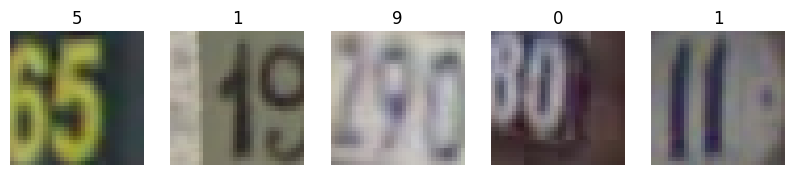

In [64]:
plotsample(train)

# 模型訓練

Epoch1:[32000/2197710(1%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:93.710519, Test Loss:44.504072, Train Acc:69.111%, Test Acc:86.436%
	 Weight Saved
Epoch2:[105257/2197710(5%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:40.112757, Test Loss:28.559595, Train Acc:87.652%, Test Acc:91.564%
	 Weight Saved
Epoch3:[178514/2197710(8%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:33.012541, Test Loss:27.953718, Train Acc:89.892%, Test Acc:91.491%
Epoch4:[251771/2197710(11%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:30.120883, Test Loss:22.236060, Train Acc:90.901%, Test Acc:93.619%
	 Weight Saved
Epoch5:[325028/2197710(15%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:27.412688, Test Loss:19.973642, Train Acc:91.743%, Test Acc:94.303%
	 Weight Saved
Epoch6:[398285/2197710(18%)]
Epoch6:[430285/2197710(20%)]
	 Train Loss:25.963722, Test Loss:20.260379, Train Acc:92.107%, Test Acc:94.272%
	 NOTICE: Early stopping counter 1 of 5
Epoch7:[471542/2197710(21%)]
Epoch7:[503542/2197710(23%)]
	 Train Loss:24

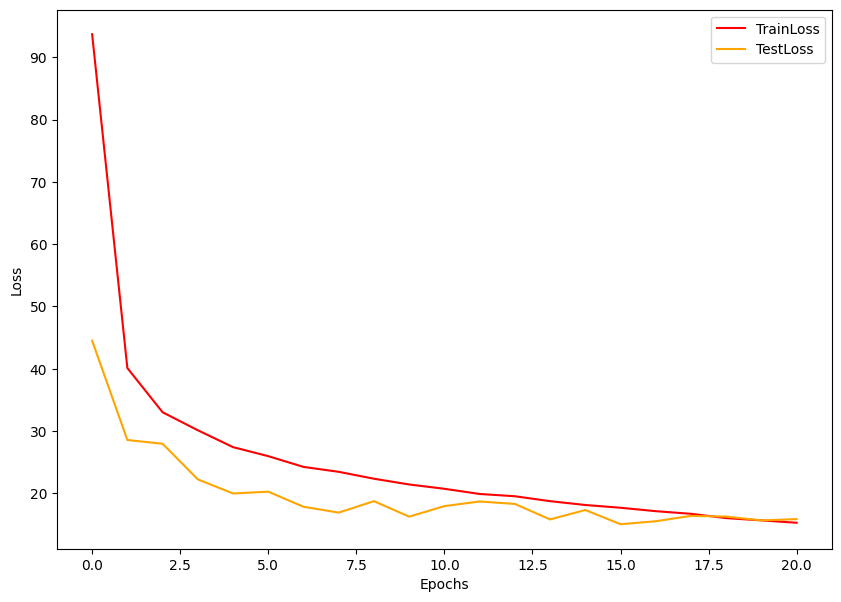

Epoch1:[32000/2197710(1%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:99.163479, Test Loss:37.149885, Train Acc:67.267%, Test Acc:88.864%
	 Weight Saved
Epoch2:[105257/2197710(5%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:40.325556, Test Loss:32.258134, Train Acc:87.518%, Test Acc:90.074%
	 Weight Saved
Epoch3:[178514/2197710(8%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:33.250218, Test Loss:30.071681, Train Acc:89.770%, Test Acc:90.600%
	 Weight Saved
Epoch4:[251771/2197710(11%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:29.851789, Test Loss:24.668840, Train Acc:90.973%, Test Acc:92.594%
	 Weight Saved
Epoch5:[325028/2197710(15%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:27.469435, Test Loss:20.441990, Train Acc:91.735%, Test Acc:94.142%
	 Weight Saved
Epoch6:[398285/2197710(18%)]
Epoch6:[430285/2197710(20%)]
	 Train Loss:25.742823, Test Loss:23.048911, Train Acc:92.331%, Test Acc:93.546%
	 NOTICE: Early stopping counter 1 of 5
Epoch7:[471542/2197710(21%)]
Epoch7:[503542/2197710(23%)]


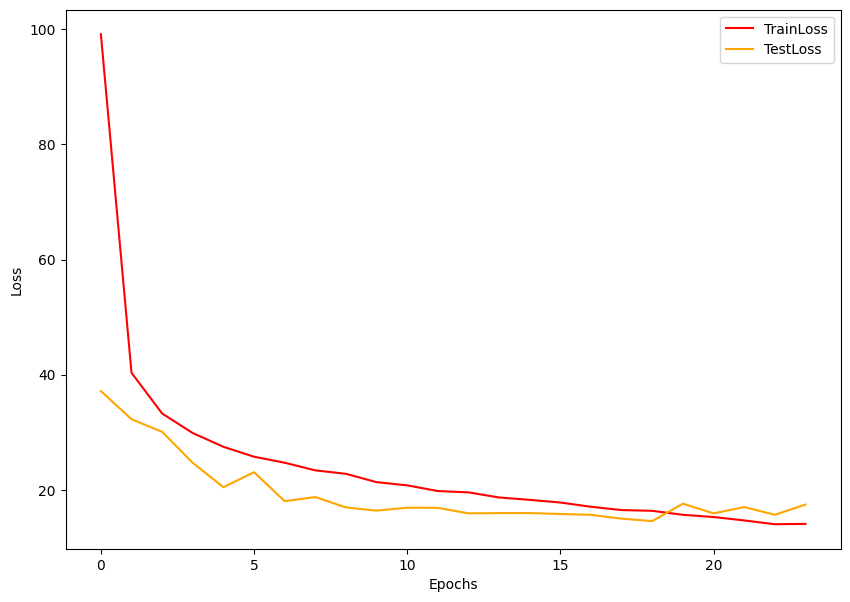

Epoch1:[32000/2197710(1%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:96.450571, Test Loss:33.982740, Train Acc:68.251%, Test Acc:90.051%
	 Weight Saved
Epoch2:[105257/2197710(5%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:40.508491, Test Loss:31.929779, Train Acc:87.590%, Test Acc:90.496%
	 Weight Saved
Epoch3:[178514/2197710(8%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:33.425529, Test Loss:27.833724, Train Acc:89.804%, Test Acc:91.330%
	 Weight Saved
Epoch4:[251771/2197710(11%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:29.614484, Test Loss:22.409306, Train Acc:91.105%, Test Acc:93.523%
	 Weight Saved
Epoch5:[325028/2197710(15%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:27.467355, Test Loss:19.884894, Train Acc:91.720%, Test Acc:94.395%
	 Weight Saved
Epoch6:[398285/2197710(18%)]
Epoch6:[430285/2197710(20%)]
	 Train Loss:25.788360, Test Loss:17.960945, Train Acc:92.298%, Test Acc:94.949%
	 Weight Saved
Epoch7:[471542/2197710(21%)]
Epoch7:[503542/2197710(23%)]
	 Train Loss:24.436578, T

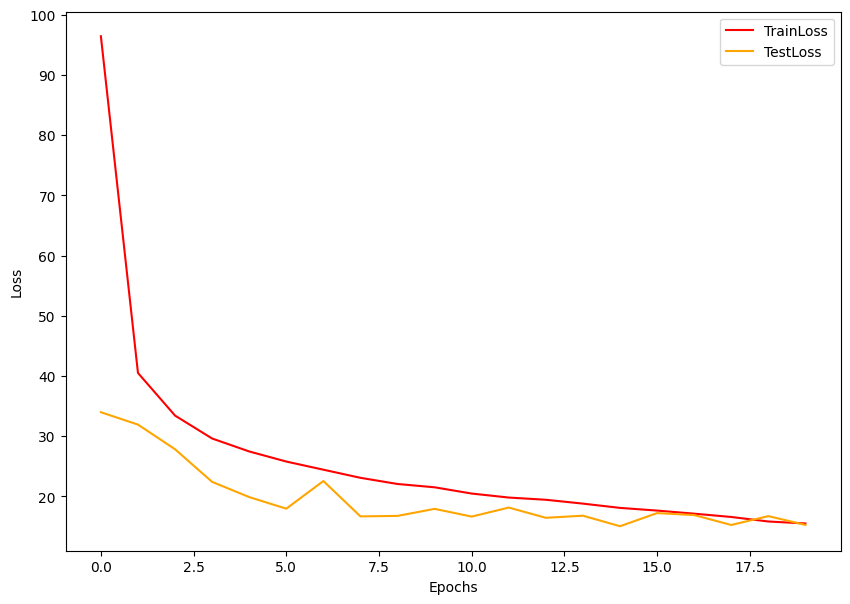

In [35]:
for modelname in ["MyResNet_test1", "MyResNet_test2", "MyResNet_test3"]:
    resnet18_ = models.resnet18()
    net = MyResNet()

    trainloss, testloss = fit_test(
        net=net, 
        traindata=DataLoader(train, batch_size=256, shuffle=True, drop_last=False, pin_memory=True), 
        testdata=DataLoader(test, batch_size=256, shuffle=False, drop_last=False, pin_memory=True), 
        criterion=nn.CrossEntropyLoss(reduction="sum") , 
        optimizer=optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999)), 
        epochs=30, 
        modelname=modelname, 
        PATH=r"Weights_Practice", 
        scheduler_lr_lambda=None, 
        patience=5, tolerance=10**(-10), speedup=True)
    
    plotloss(trainloss, testloss)

Epoch1:[32000/2197710(1%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:12.628430, Test Loss:13.320296, Train Acc:96.388%, Test Acc:96.466%
	 Weight Saved
Epoch2:[105257/2197710(5%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:11.347277, Test Loss:13.363950, Train Acc:96.817%, Test Acc:96.458%
	 NOTICE: Early stopping counter 1 of 5
Epoch3:[178514/2197710(8%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:10.675784, Test Loss:13.423410, Train Acc:97.030%, Test Acc:96.504%
	 Weight Saved
	 NOTICE: Early stopping counter 2 of 5
Epoch4:[251771/2197710(11%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:10.200536, Test Loss:13.495551, Train Acc:97.176%, Test Acc:96.416%
	 NOTICE: Early stopping counter 3 of 5
Epoch5:[325028/2197710(15%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:9.785817, Test Loss:13.862616, Train Acc:97.323%, Test Acc:96.358%
	 NOTICE: Early stopping counter 4 of 5
Epoch6:[398285/2197710(18%)]
Epoch6:[430285/2197710(20%)]
	 Train Loss:9.597586, Test Loss:13.858607, Train Acc:97.296%, Te

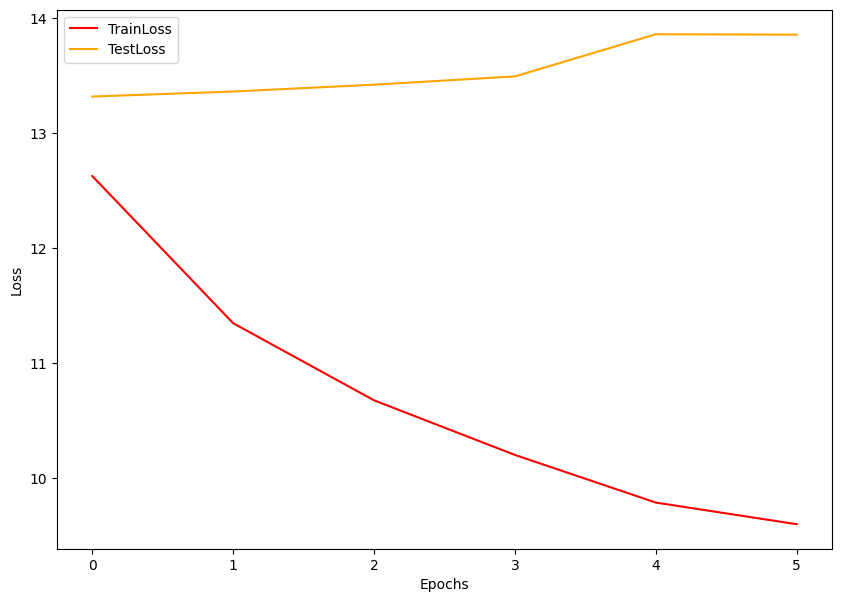

In [38]:
# 用最高測試集準確率的模型來實驗(96.189%)，加入學習率遞減策略
resnet18_ = models.resnet18()
net = MyResNet()
modelname = "MyResNet_LRdecay1"
net.load_state_dict(torch.load(os.path.join("Weights_Practice", "MyResNet_test2.pt")))  # 96.189%

trainloss, testloss = fit_test(
    net=net, 
    traindata=DataLoader(train, batch_size=256, shuffle=True, drop_last=False, pin_memory=True), 
    testdata=DataLoader(test, batch_size=256, shuffle=False, drop_last=False, pin_memory=True), 
    criterion=nn.CrossEntropyLoss(reduction="sum") , 
    optimizer=optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999)), 
    epochs=30, 
    modelname=modelname, 
    PATH=r"Weights_Practice", 
    scheduler_lr_lambda=lambda epoch: 0.99 ** epoch, 
    patience=5, tolerance=10**(-10), speedup=True)
    
plotloss(trainloss, testloss)

Epoch1:[16000/2197710(1%)]
Epoch1:[32000/2197710(1%)]
Epoch1:[48000/2197710(2%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:10.198763, Test Loss:13.256137, Train Acc:97.127%, Test Acc:96.527%
	 Weight Saved
Epoch2:[89257/2197710(4%)]
Epoch2:[105257/2197710(5%)]
Epoch2:[121257/2197710(6%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:10.174739, Test Loss:13.318393, Train Acc:97.237%, Test Acc:96.508%
	 NOTICE: Early stopping counter 1 of 5
Epoch3:[162514/2197710(7%)]
Epoch3:[178514/2197710(8%)]
Epoch3:[194514/2197710(9%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:10.341955, Test Loss:13.268593, Train Acc:97.112%, Test Acc:96.497%
	 NOTICE: Early stopping counter 2 of 5
Epoch4:[235771/2197710(11%)]
Epoch4:[251771/2197710(11%)]
Epoch4:[267771/2197710(12%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:9.841568, Test Loss:13.250666, Train Acc:97.198%, Test Acc:96.500%
Epoch5:[309028/2197710(14%)]
Epoch5:[325028/2197710(15%)]
Epoch5:[341028/2197710(16%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:9.913

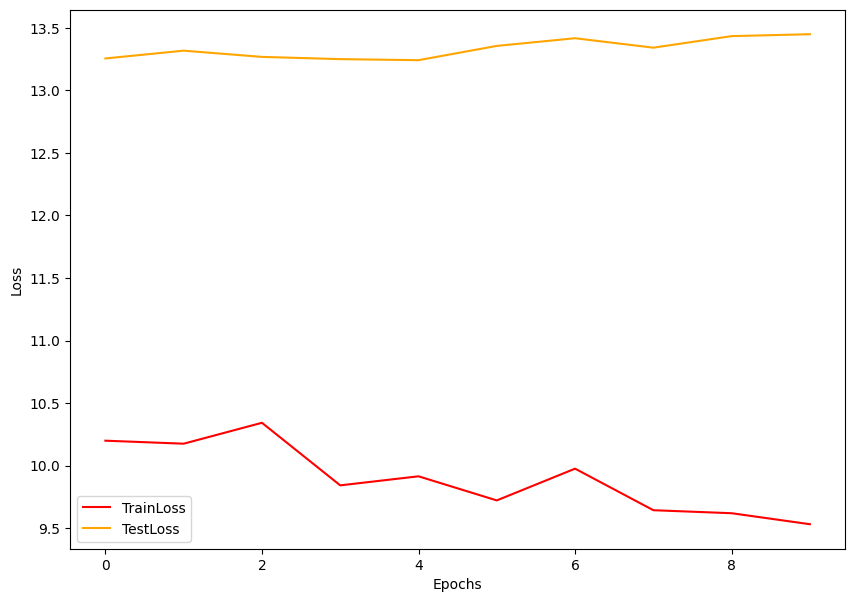

In [41]:
# 用最高測試集準確率的模型來實驗(96.504%)，過擬合  ---> 96.527%
resnet18_ = models.resnet18()
net = MyResNet()
modelname = "MyResNet_LRdecay_Overfit1"
net.load_state_dict(torch.load(os.path.join("Weights_Practice", "MyResNet_LRdecay1.pt")))  # 96.189%

trainloss, testloss = fit_test(
    net=net, 
    traindata=DataLoader(train, batch_size=128, shuffle=True, drop_last=False, pin_memory=True), 
    testdata=DataLoader(test, batch_size=128, shuffle=False, drop_last=False, pin_memory=True), 
    criterion=nn.CrossEntropyLoss(reduction="sum"), 
    optimizer=optim.Adam(net.parameters(), lr=0.00001, betas=(0.9, 0.999)), 
    epochs=30, 
    modelname=modelname, 
    PATH=r"Weights_Practice", 
    scheduler_lr_lambda=None, 
    patience=5, tolerance=10**(-10), speedup=True)
    
plotloss(trainloss, testloss)

Epoch1:[16000/2197710(1%)]
Epoch1:[32000/2197710(1%)]
Epoch1:[48000/2197710(2%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:10.129982, Test Loss:13.255348, Train Acc:97.192%, Test Acc:96.527%
	 Weight Saved
Epoch2:[89257/2197710(4%)]
Epoch2:[105257/2197710(5%)]
Epoch2:[121257/2197710(6%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:10.066115, Test Loss:13.227296, Train Acc:97.191%, Test Acc:96.520%
Epoch3:[162514/2197710(7%)]
Epoch3:[178514/2197710(8%)]
Epoch3:[194514/2197710(9%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:10.192924, Test Loss:13.331515, Train Acc:97.139%, Test Acc:96.500%
	 NOTICE: Early stopping counter 1 of 5
Epoch4:[235771/2197710(11%)]
Epoch4:[251771/2197710(11%)]
Epoch4:[267771/2197710(12%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:9.997010, Test Loss:13.321766, Train Acc:97.245%, Test Acc:96.481%
	 NOTICE: Early stopping counter 2 of 5
Epoch5:[309028/2197710(14%)]
Epoch5:[325028/2197710(15%)]
Epoch5:[341028/2197710(16%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:9.696

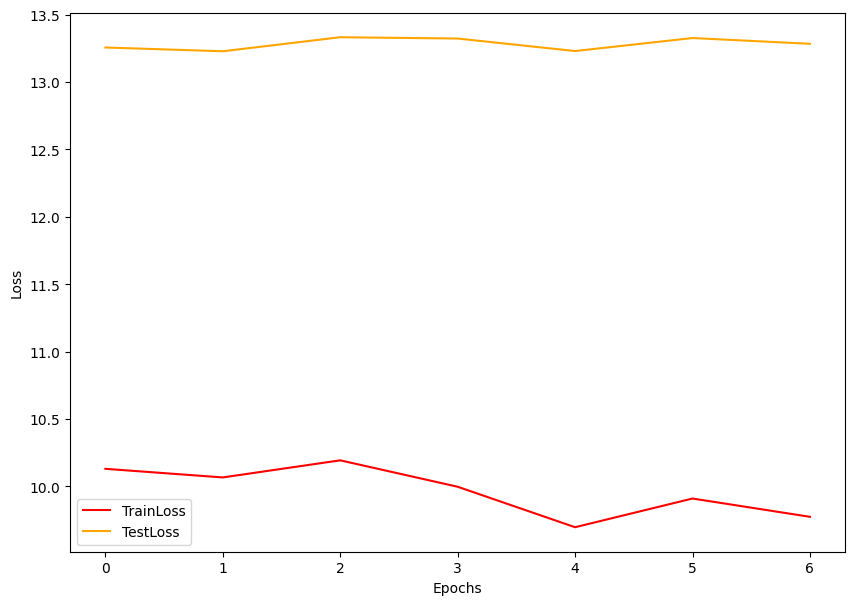

In [42]:
# 用最高測試集準確率的模型來實驗(96.527%)，過擬合  
resnet18_ = models.resnet18()
net = MyResNet()
modelname = "MyResNet_LRdecay_Overfit2"
net.load_state_dict(torch.load(os.path.join("Weights_Practice", "MyResNet_LRdecay_Overfit1.pt")))  # 96.189%

trainloss, testloss = fit_test(
    net=net, 
    traindata=DataLoader(train, batch_size=128, shuffle=True, drop_last=False, pin_memory=True), 
    testdata=DataLoader(test, batch_size=128, shuffle=False, drop_last=False, pin_memory=True), 
    criterion=nn.CrossEntropyLoss(reduction="sum"), 
    optimizer=optim.Adam(net.parameters(), lr=0.000005, betas=(0.9, 0.999)), 
    epochs=30, 
    modelname=modelname, 
    PATH=r"Weights_Practice", 
    scheduler_lr_lambda=lambda epoch: 0.99 ** epoch, 
    patience=5, tolerance=10**(-10), speedup=True)
    
plotloss(trainloss, testloss)

## 加深網路

Epoch1:[32000/2197710(1%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:91.831238, Test Loss:49.047360, Train Acc:69.191%, Test Acc:83.966%
	 Weight Saved
Epoch2:[105257/2197710(5%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:40.187839, Test Loss:26.007937, Train Acc:87.439%, Test Acc:92.509%
	 Weight Saved
Epoch3:[178514/2197710(8%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:33.289170, Test Loss:28.240447, Train Acc:89.770%, Test Acc:91.795%
	 NOTICE: Early stopping counter 1 of 5
Epoch4:[251771/2197710(11%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:30.219092, Test Loss:22.306625, Train Acc:90.827%, Test Acc:93.516%
	 Weight Saved
Epoch5:[325028/2197710(15%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:27.906893, Test Loss:19.207750, Train Acc:91.478%, Test Acc:94.480%
	 Weight Saved
Epoch6:[398285/2197710(18%)]
Epoch6:[430285/2197710(20%)]
	 Train Loss:26.280762, Test Loss:20.657859, Train Acc:92.125%, Test Acc:94.092%
	 NOTICE: Early stopping counter 1 of 5
Epoch7:[471542/2197710(21%)]
Epoc

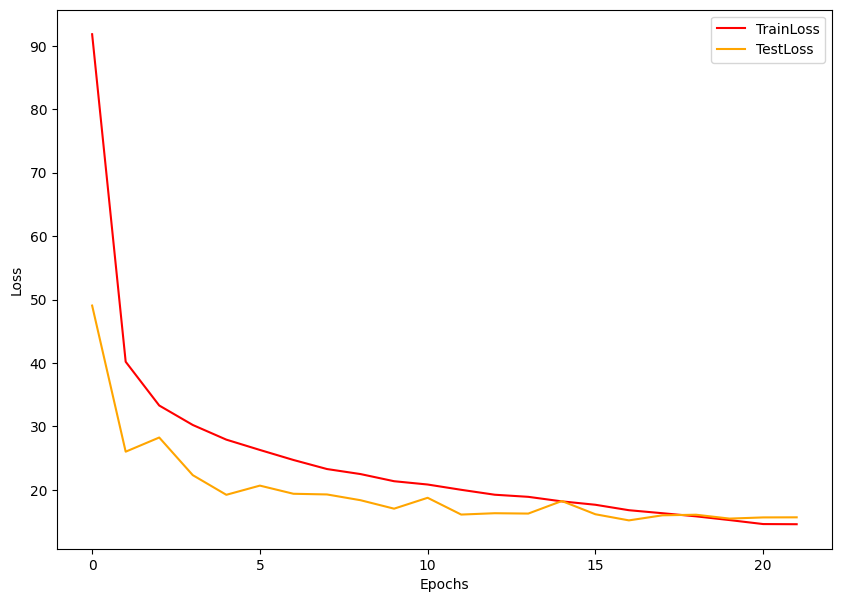

Epoch1:[32000/2197710(1%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:89.131701, Test Loss:39.034035, Train Acc:70.400%, Test Acc:87.800%
	 Weight Saved
Epoch2:[105257/2197710(5%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:40.532420, Test Loss:28.097875, Train Acc:87.399%, Test Acc:91.829%
	 Weight Saved
Epoch3:[178514/2197710(8%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:33.820055, Test Loss:25.625197, Train Acc:89.609%, Test Acc:92.432%
	 Weight Saved
Epoch4:[251771/2197710(11%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:30.599557, Test Loss:22.274984, Train Acc:90.623%, Test Acc:93.608%
	 Weight Saved
Epoch5:[325028/2197710(15%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:27.925331, Test Loss:21.102701, Train Acc:91.524%, Test Acc:94.053%
	 Weight Saved
Epoch6:[398285/2197710(18%)]
Epoch6:[430285/2197710(20%)]
	 Train Loss:26.308337, Test Loss:22.063155, Train Acc:92.115%, Test Acc:93.731%
	 NOTICE: Early stopping counter 1 of 5
Epoch7:[471542/2197710(21%)]
Epoch7:[503542/2197710(23%)]


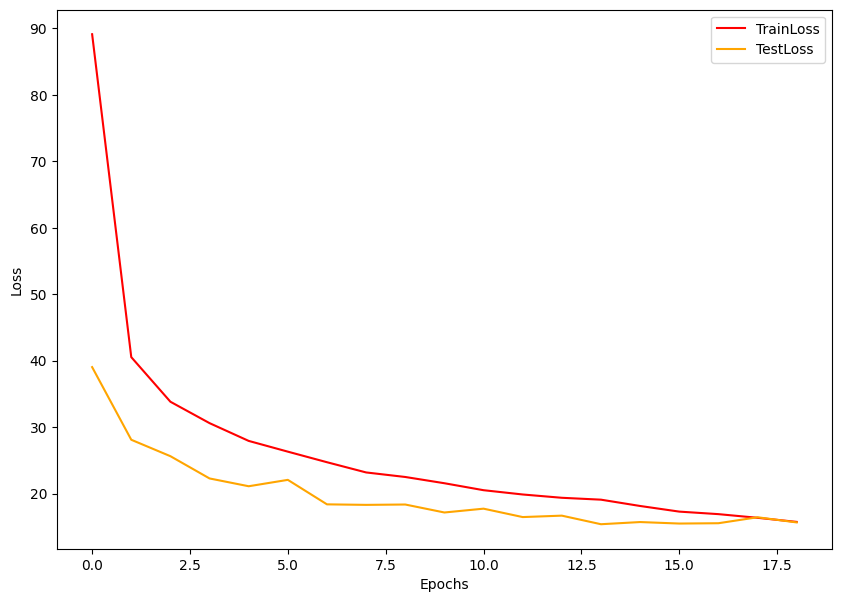

Epoch1:[32000/2197710(1%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:89.963321, Test Loss:43.391969, Train Acc:70.068%, Test Acc:86.271%
	 Weight Saved
Epoch2:[105257/2197710(5%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:40.185989, Test Loss:32.162214, Train Acc:87.482%, Test Acc:90.435%
	 Weight Saved
Epoch3:[178514/2197710(8%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:33.600734, Test Loss:23.520801, Train Acc:89.748%, Test Acc:93.089%
	 Weight Saved
Epoch4:[251771/2197710(11%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:29.989803, Test Loss:23.165198, Train Acc:91.004%, Test Acc:93.504%
	 Weight Saved
Epoch5:[325028/2197710(15%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:27.850496, Test Loss:19.711140, Train Acc:91.621%, Test Acc:94.411%
	 Weight Saved
Epoch6:[398285/2197710(18%)]
Epoch6:[430285/2197710(20%)]
	 Train Loss:25.928964, Test Loss:24.979576, Train Acc:92.301%, Test Acc:93.001%
	 NOTICE: Early stopping counter 1 of 5
Epoch7:[471542/2197710(21%)]
Epoch7:[503542/2197710(23%)]


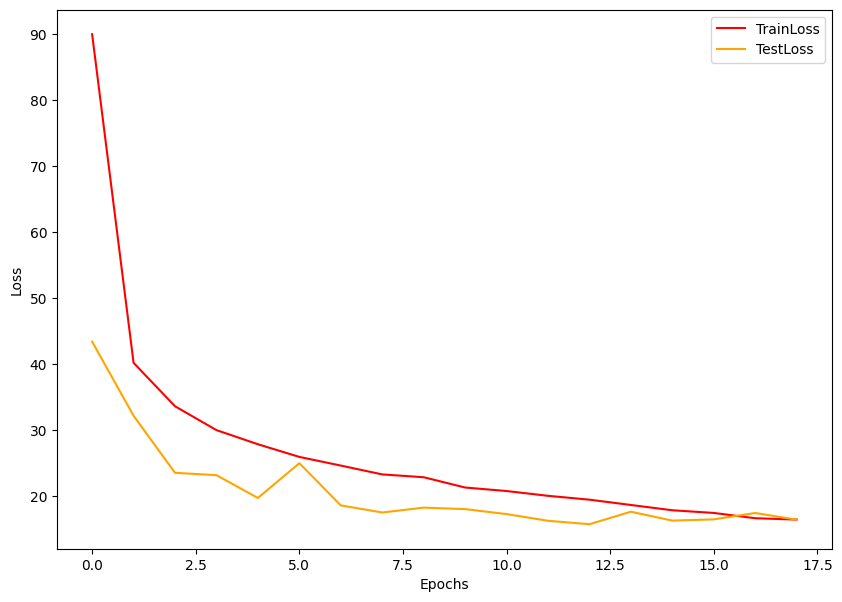

In [43]:
for modelname in ["MyResNet2_test1", "MyResNet2_test2", "MyResNet2_test3"]:
    resnet18_ = models.resnet18()
    net = MyResNet2()

    trainloss, testloss = fit_test(
        net=net, 
        traindata=DataLoader(train, batch_size=256, shuffle=True, drop_last=False, pin_memory=True), 
        testdata=DataLoader(test, batch_size=256, shuffle=False, drop_last=False, pin_memory=True), 
        criterion=nn.CrossEntropyLoss(reduction="sum"), 
        optimizer=optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999)), 
        epochs=30, 
        modelname=modelname, 
        PATH=r"Weights_Practice", 
        scheduler_lr_lambda=None, 
        patience=5, tolerance=10**(-10), speedup=True)
    
    plotloss(trainloss, testloss)

Epoch1:[32000/2197710(1%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:15.049183, Test Loss:17.168360, Train Acc:95.577%, Test Acc:95.379%
	 Weight Saved
Epoch2:[105257/2197710(5%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:14.142607, Test Loss:16.406668, Train Acc:95.882%, Test Acc:95.467%
	 Weight Saved
Epoch3:[178514/2197710(8%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:13.726537, Test Loss:16.708130, Train Acc:95.888%, Test Acc:95.371%
	 NOTICE: Early stopping counter 1 of 5
Epoch4:[251771/2197710(11%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:12.715078, Test Loss:16.407998, Train Acc:96.243%, Test Acc:95.682%
	 Weight Saved
	 NOTICE: Early stopping counter 2 of 5
Epoch5:[325028/2197710(15%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:12.343309, Test Loss:14.994791, Train Acc:96.470%, Test Acc:96.166%
	 Weight Saved
Epoch6:[398285/2197710(18%)]
Epoch6:[430285/2197710(20%)]
	 Train Loss:11.941325, Test Loss:15.990479, Train Acc:96.527%, Test Acc:95.913%
	 NOTICE: Early stopping counter 

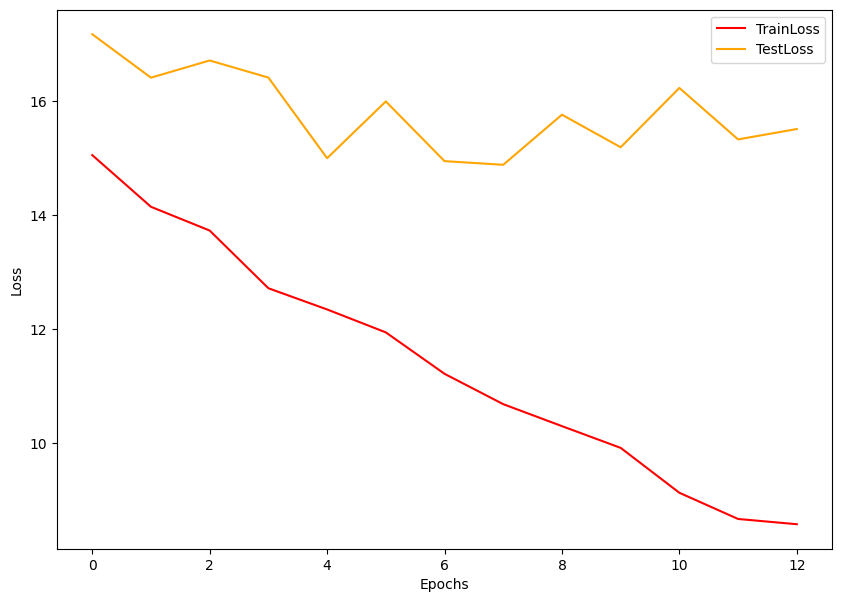

Epoch1:[32000/2197710(1%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:18.855155, Test Loss:17.628224, Train Acc:94.504%, Test Acc:95.233%
	 Weight Saved
Epoch2:[105257/2197710(5%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:18.159244, Test Loss:15.821966, Train Acc:94.717%, Test Acc:95.794%
	 Weight Saved
Epoch3:[178514/2197710(8%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:17.097827, Test Loss:15.638519, Train Acc:94.996%, Test Acc:95.913%
	 Weight Saved
Epoch4:[251771/2197710(11%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:16.481898, Test Loss:14.976751, Train Acc:95.213%, Test Acc:95.951%
	 Weight Saved
Epoch5:[325028/2197710(15%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:15.499563, Test Loss:16.490645, Train Acc:95.483%, Test Acc:95.640%
	 NOTICE: Early stopping counter 1 of 5
Epoch6:[398285/2197710(18%)]
Epoch6:[430285/2197710(20%)]
	 Train Loss:15.045787, Test Loss:16.208563, Train Acc:95.561%, Test Acc:95.506%
	 NOTICE: Early stopping counter 2 of 5
Epoch7:[471542/2197710(21%)]
Epoc

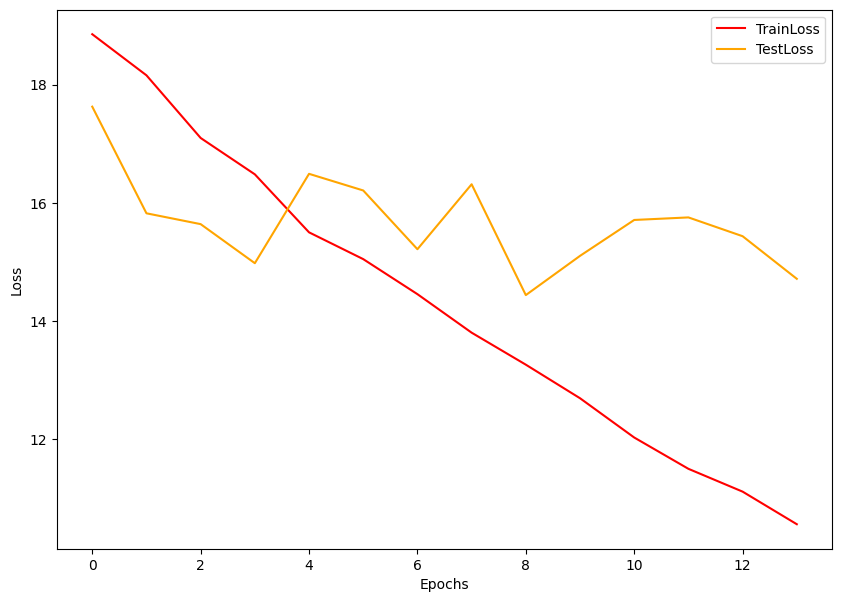

Epoch1:[32000/2197710(1%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:19.533130, Test Loss:17.877844, Train Acc:94.209%, Test Acc:95.098%
	 Weight Saved
Epoch2:[105257/2197710(5%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:18.529272, Test Loss:15.053758, Train Acc:94.553%, Test Acc:95.890%
	 Weight Saved
Epoch3:[178514/2197710(8%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:17.910340, Test Loss:17.346102, Train Acc:94.667%, Test Acc:95.283%
	 NOTICE: Early stopping counter 1 of 5
Epoch4:[251771/2197710(11%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:17.256022, Test Loss:17.858095, Train Acc:94.933%, Test Acc:95.156%
	 NOTICE: Early stopping counter 2 of 5
Epoch5:[325028/2197710(15%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:16.273250, Test Loss:14.496021, Train Acc:95.150%, Test Acc:96.174%
	 Weight Saved
Epoch6:[398285/2197710(18%)]
Epoch6:[430285/2197710(20%)]
	 Train Loss:15.782551, Test Loss:15.562067, Train Acc:95.363%, Test Acc:95.863%
	 NOTICE: Early stopping counter 1 of 5
Epoch7:[

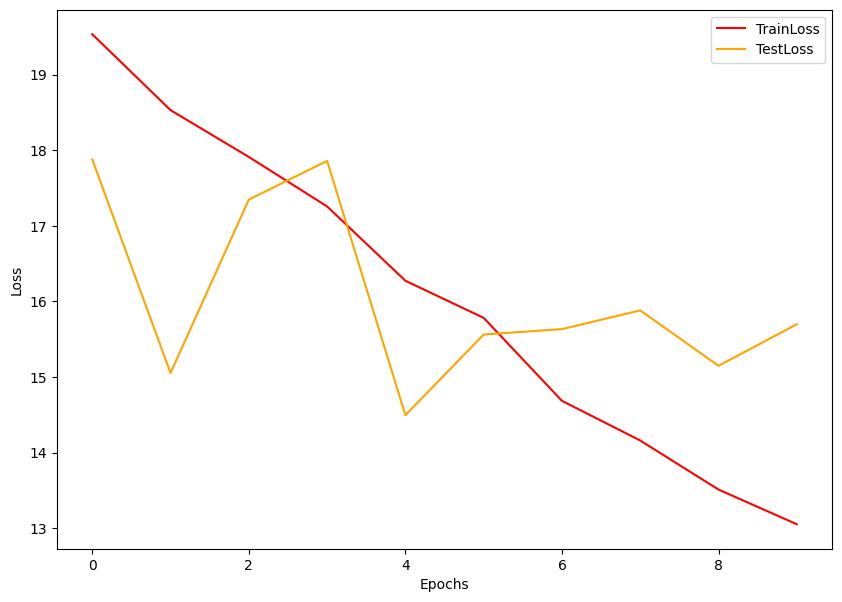

In [16]:
# 測試準確率均高於訓練準確率，因此持續保持訓練
filename_l = ["MyResNet2_test1.pt", "MyResNet2_test2.pt", "MyResNet2_test3.pt"]
modelname_l = ["MyResNet2_1", "MyResNet2_2", "MyResNet2_3"]
for filename, modelname in zip(filename_l, modelname_l):
    resnet18_ = models.resnet18()
    net = MyResNet2()
    net.load_state_dict(torch.load(os.path.join("Weights_Practice", filename)))
    trainloss, testloss = fit_test(
        net=net, 
        traindata=DataLoader(train, batch_size=256, shuffle=True, drop_last=False, pin_memory=True), 
        testdata=DataLoader(test, batch_size=256, shuffle=False, drop_last=False, pin_memory=True), 
        criterion=nn.CrossEntropyLoss(reduction="sum"), 
        optimizer=optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999)), 
        epochs=30, 
        modelname=modelname, 
        PATH=r"Weights_Practice", 
        scheduler_lr_lambda=lambda epoch: 0.98 ** epoch, 
        patience=5, 
        tolerance=10**(-10), 
        speedup=True)
    
    plotloss(trainloss, testloss)

Epoch1:[32000/2197710(1%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:7.658527, Test Loss:13.710701, Train Acc:97.776%, Test Acc:96.631%
	 Weight Saved
Epoch2:[105257/2197710(5%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:6.777746, Test Loss:13.868274, Train Acc:98.010%, Test Acc:96.616%
	 NOTICE: Early stopping counter 1 of 5
Epoch3:[178514/2197710(8%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:6.240042, Test Loss:13.958897, Train Acc:98.206%, Test Acc:96.566%
	 NOTICE: Early stopping counter 2 of 5
Epoch4:[251771/2197710(11%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:5.954785, Test Loss:14.390405, Train Acc:98.245%, Test Acc:96.527%
	 NOTICE: Early stopping counter 3 of 5
Epoch5:[325028/2197710(15%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:5.759743, Test Loss:14.197311, Train Acc:98.370%, Test Acc:96.616%
	 NOTICE: Early stopping counter 4 of 5
Epoch6:[398285/2197710(18%)]
Epoch6:[430285/2197710(20%)]
	 Train Loss:5.433925, Test Loss:14.340541, Train Acc:98.447%, Test Acc:96.612%
	 NO

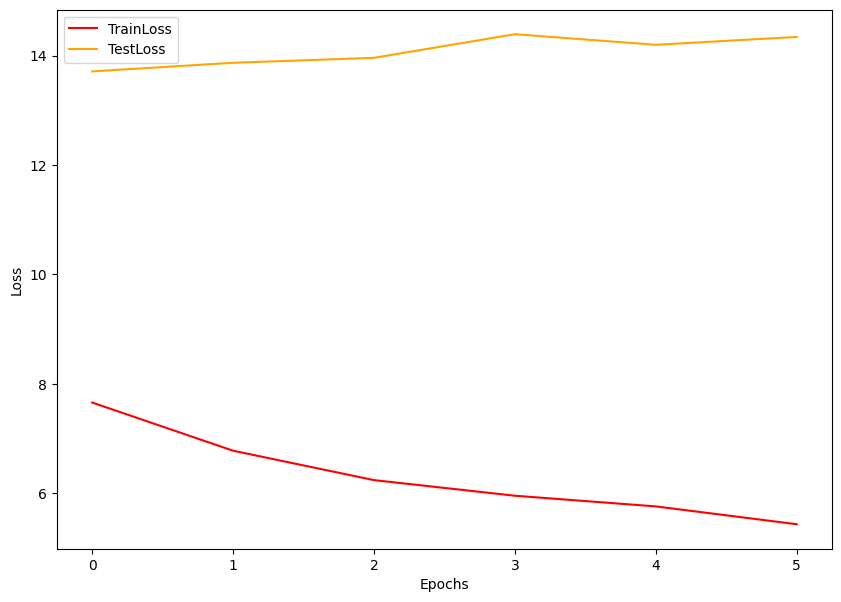

In [18]:
# 最高測試準確率96.289%，些微過擬合，測試集損失曲線不穩定，降低學習率繼續訓練
resnet18_ = models.resnet18()
net = MyResNet2()
net.load_state_dict(torch.load(os.path.join("Weights_Practice", "MyResNet2_2.pt")))
modelname = "MyResNet2_2_Overfit"
    
trainloss, testloss = fit_test(
    net=net, 
    traindata=DataLoader(train, batch_size=256, shuffle=True, drop_last=False, pin_memory=True), 
    testdata=DataLoader(test, batch_size=256, shuffle=False, drop_last=False, pin_memory=True), 
    criterion=nn.CrossEntropyLoss(reduction="sum"), 
    optimizer=optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999)), 
    epochs=30, 
    modelname=modelname, 
    PATH=r"Weights_Practice", 
    scheduler_lr_lambda=lambda epoch: 0.98 ** epoch, 
    patience=5, 
    tolerance=10**(-10), 
    speedup=True)
    
plotloss(trainloss, testloss)

Epoch1:[25000/2197710(1%)]
Epoch1:[50000/2197710(2%)]
	 Train Loss:6.771625, Test Loss:13.669777, Train Acc:98.094%, Test Acc:96.643%
	 Weight Saved
Epoch2:[98257/2197710(4%)]
Epoch2:[123257/2197710(6%)]
	 Train Loss:6.721972, Test Loss:13.540938, Train Acc:98.122%, Test Acc:96.719%
	 Weight Saved
Epoch3:[171514/2197710(8%)]
Epoch3:[196514/2197710(9%)]
	 Train Loss:6.689473, Test Loss:13.483589, Train Acc:98.100%, Test Acc:96.739%
	 Weight Saved
Epoch4:[244771/2197710(11%)]
Epoch4:[269771/2197710(12%)]
	 Train Loss:6.429897, Test Loss:13.479350, Train Acc:98.210%, Test Acc:96.746%
	 Weight Saved
Epoch5:[318028/2197710(14%)]
Epoch5:[343028/2197710(16%)]
	 Train Loss:6.242625, Test Loss:13.602871, Train Acc:98.230%, Test Acc:96.700%
	 NOTICE: Early stopping counter 1 of 5
Epoch6:[391285/2197710(18%)]
Epoch6:[416285/2197710(19%)]
	 Train Loss:6.194640, Test Loss:13.595044, Train Acc:98.253%, Test Acc:96.716%
	 NOTICE: Early stopping counter 2 of 5
Epoch7:[464542/2197710(21%)]
Epoch7:[4895

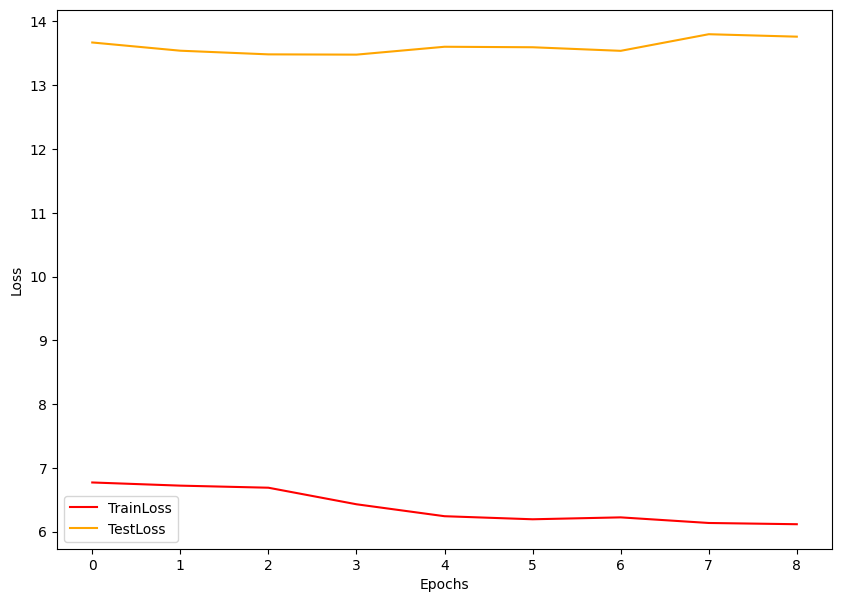

In [19]:
# 最高測試準確率96.631%，些微過擬合，測試集損失曲線趨於穩定，降低學習率減小batch繼續訓練
resnet18_ = models.resnet18()
net = MyResNet2()
net.load_state_dict(torch.load(os.path.join("Weights_Practice", "MyResNet2_2_Overfit.pt")))
modelname = "MyResNet2_2_Overfit1"
    
trainloss, testloss = fit_test(
    net=net, 
    traindata=DataLoader(train, batch_size=200, shuffle=True, drop_last=False, pin_memory=True), 
    testdata=DataLoader(test, batch_size=200, shuffle=False, drop_last=False, pin_memory=True), 
    criterion=nn.CrossEntropyLoss(reduction="sum"), 
    optimizer=optim.Adam(net.parameters(), lr=0.00001, betas=(0.9, 0.999)), 
    epochs=30, 
    modelname=modelname, 
    PATH=r"Weights_Practice", 
    scheduler_lr_lambda=None, 
    patience=5, 
    tolerance=10**(-10), 
    speedup=True)
    
plotloss(trainloss, testloss)

Epoch1:[22500/2197710(1%)]
Epoch1:[45000/2197710(2%)]
Epoch1:[67500/2197710(3%)]
	 Train Loss:6.444220, Test Loss:13.515567, Train Acc:98.134%, Test Acc:96.727%
	 Weight Saved
Epoch2:[95757/2197710(4%)]
Epoch2:[118257/2197710(5%)]
Epoch2:[140757/2197710(6%)]
	 Train Loss:6.446061, Test Loss:13.499317, Train Acc:98.150%, Test Acc:96.727%
Epoch3:[169014/2197710(8%)]
Epoch3:[191514/2197710(9%)]
Epoch3:[214014/2197710(10%)]
	 Train Loss:6.388377, Test Loss:13.459360, Train Acc:98.171%, Test Acc:96.750%
	 Weight Saved
Epoch4:[242271/2197710(11%)]
Epoch4:[264771/2197710(12%)]
Epoch4:[287271/2197710(13%)]
	 Train Loss:6.236279, Test Loss:13.617807, Train Acc:98.245%, Test Acc:96.677%
	 NOTICE: Early stopping counter 1 of 5
Epoch5:[315528/2197710(14%)]
Epoch5:[338028/2197710(15%)]
Epoch5:[360528/2197710(16%)]
	 Train Loss:6.241235, Test Loss:13.532578, Train Acc:98.250%, Test Acc:96.792%
	 Weight Saved
	 NOTICE: Early stopping counter 2 of 5
Epoch6:[388785/2197710(18%)]
Epoch6:[411285/2197710(

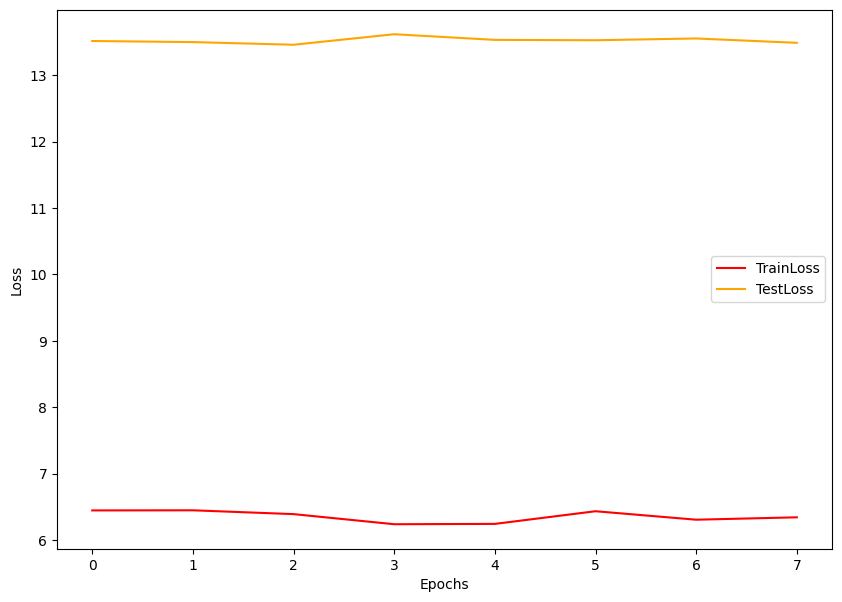

In [20]:
# 最高測試準確率96.746%，過擬合，測試集損失曲線趨於穩定，降低學習率減小batch繼續訓練  ---> 96.792%
resnet18_ = models.resnet18()
net = MyResNet2()
net.load_state_dict(torch.load(os.path.join("Weights_Practice", "MyResNet2_2_Overfit1.pt")))
modelname = "MyResNet2_2_Overfit2"
    
trainloss, testloss = fit_test(
    net=net, 
    traindata=DataLoader(train, batch_size=180, shuffle=True, drop_last=False, pin_memory=True), 
    testdata=DataLoader(test, batch_size=180, shuffle=False, drop_last=False, pin_memory=True), 
    criterion=nn.CrossEntropyLoss(reduction="sum"), 
    optimizer=optim.Adam(net.parameters(), lr=0.000001, betas=(0.9, 0.999)), 
    epochs=30, 
    modelname=modelname, 
    PATH=r"Weights_Practice", 
    scheduler_lr_lambda=None, 
    patience=5, 
    tolerance=10**(-10), 
    speedup=True)
    
plotloss(trainloss, testloss)

Epoch1:[16000/2197710(1%)]
Epoch1:[32000/2197710(1%)]
Epoch1:[48000/2197710(2%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:6.461454, Test Loss:13.598800, Train Acc:98.105%, Test Acc:96.689%
	 Weight Saved
Epoch2:[89257/2197710(4%)]
Epoch2:[105257/2197710(5%)]
Epoch2:[121257/2197710(6%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:6.414195, Test Loss:13.631981, Train Acc:98.198%, Test Acc:96.662%
	 NOTICE: Early stopping counter 1 of 8
Epoch3:[162514/2197710(7%)]
Epoch3:[178514/2197710(8%)]
Epoch3:[194514/2197710(9%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:6.407367, Test Loss:13.669534, Train Acc:98.193%, Test Acc:96.658%
	 NOTICE: Early stopping counter 2 of 8
Epoch4:[235771/2197710(11%)]
Epoch4:[251771/2197710(11%)]
Epoch4:[267771/2197710(12%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:6.274586, Test Loss:13.470195, Train Acc:98.197%, Test Acc:96.739%
	 Weight Saved
Epoch5:[309028/2197710(14%)]
Epoch5:[325028/2197710(15%)]
Epoch5:[341028/2197710(16%)]
Epoch5:[357028/2197710(16%)]
	 Trai

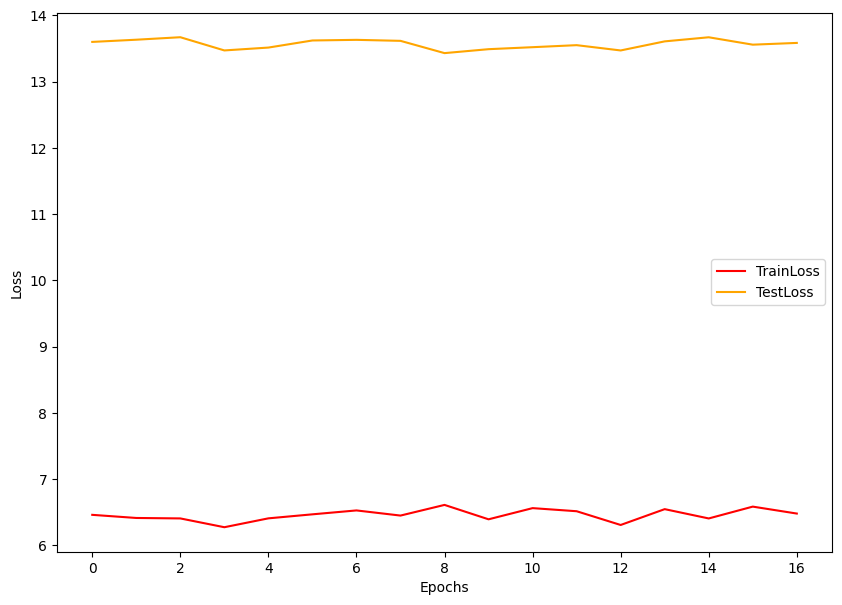

In [22]:
# 最高測試準確率96.792%，過擬合，測試集損失曲線趨於穩定，減小batch繼續訓練
resnet18_ = models.resnet18()
net = MyResNet2()
net.load_state_dict(torch.load(os.path.join("Weights_Practice", "MyResNet2_2_Overfit2.pt")))
modelname = "MyResNet2_2_Overfit3"
    
trainloss, testloss = fit_test(
    net=net, 
    traindata=DataLoader(train, batch_size=128, shuffle=True, drop_last=False, pin_memory=True), 
    testdata=DataLoader(test, batch_size=128, shuffle=False, drop_last=False, pin_memory=True), 
    criterion=nn.CrossEntropyLoss(reduction="sum"), 
    optimizer=optim.Adam(net.parameters(), lr=0.0000001, betas=(0.9, 0.999)), 
    epochs=30, 
    modelname=modelname, 
    PATH=r"Weights_Practice", 
    scheduler_lr_lambda=None, 
    patience=8, 
    tolerance=10**(-10), 
    speedup=True)
    
plotloss(trainloss, testloss)

## 最高測試集準確率: 96.792%

# 重做一次

In [68]:
import imgaug as ia
from imgaug import augmenters as iaa
from skimage import io
from PIL import Image

In [67]:
def plotsample(data, num_pics=5):
    fig, axs = plt.subplots(1, num_pics, figsize=(10, 10))
    nums = np.random.choice(len(data) - 1, num_pics)
    # nums = [1, 2, 3, 4, 5]
    for idx, num in enumerate(nums):
        # npimg = torchvision.utils.make_grid(data[num][0]).numpy()
        npimg = data[num][0].numpy()  # img: 3 * 28 * 28
        nplabel = data[num][1]  # label
        axs[idx].imshow(np.transpose(npimg, (1, 2, 0)))
        axs[idx].set_title(nplabel)
        axs[idx].axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


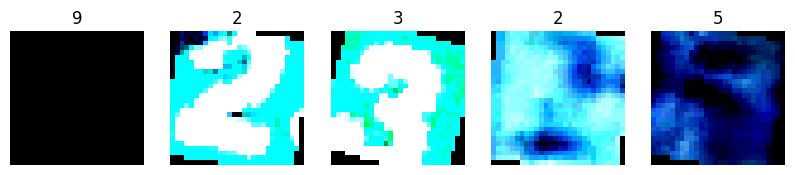

In [66]:
plotsample(train)

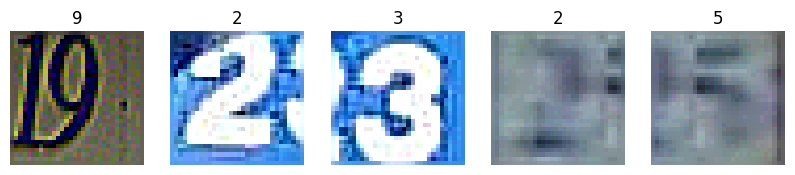

In [ ]:
plotsample(train)

In [91]:
# 定義參數
# 模型
resnet18_ = models.resnet18()
net = MyResNet()
# 數據增強
trainT = transforms.Compose([transforms.RandomCrop(28)
                             , transforms.RandomRotation(degrees=[-30, 30])
                             , transforms.ToTensor()
                             , transforms.Normalize(mean=[0.485,0.456,0.406]  # ImageNet上的均植和方差
                                                   ,std=[0.229,0.224,0.225])
                            ])
testT = transforms.Compose([transforms.CenterCrop(28)
                            , transforms.ToTensor()
                            , transforms.Normalize(mean=[0.485,0.456,0.406]  # ImageNet上的均植和方差
                                                   ,std=[0.229,0.224,0.225])
                           ])
# 數據
train = torchvision.datasets.SVHN(root='Image\datasets\SVHN'
                                 ,split="train"
                                 ,download=False
                                 ,transform=trainT
                                 )
test = torchvision.datasets.SVHN(root='Image\datasets\SVHN'
                                 ,split="test" 
                                 ,download=False
                                 ,transform=testT)

In [94]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Epoch1:[32000/2197710(1%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:12.413168, Test Loss:13.368859, Train Acc:96.515%, Test Acc:96.408%
	 Weight Saved
Epoch2:[105257/2197710(5%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:11.302359, Test Loss:13.382162, Train Acc:96.840%, Test Acc:96.454%
	 Weight Saved
	 NOTICE: Early stopping counter 1 of 5
Epoch3:[178514/2197710(8%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:10.824693, Test Loss:13.126742, Train Acc:96.967%, Test Acc:96.535%
	 Weight Saved
Epoch4:[251771/2197710(11%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:10.102065, Test Loss:13.458419, Train Acc:97.174%, Test Acc:96.474%
	 NOTICE: Early stopping counter 1 of 5
Epoch5:[325028/2197710(15%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:9.767429, Test Loss:13.753175, Train Acc:97.278%, Test Acc:96.374%
	 NOTICE: Early stopping counter 2 of 5
Epoch6:[398285/2197710(18%)]
Epoch6:[430285/2197710(20%)]
	 Train Loss:9.574307, Test Loss:13.782806, Train Acc:97.292%, Test Acc:96.458%
	 NOTICE: 

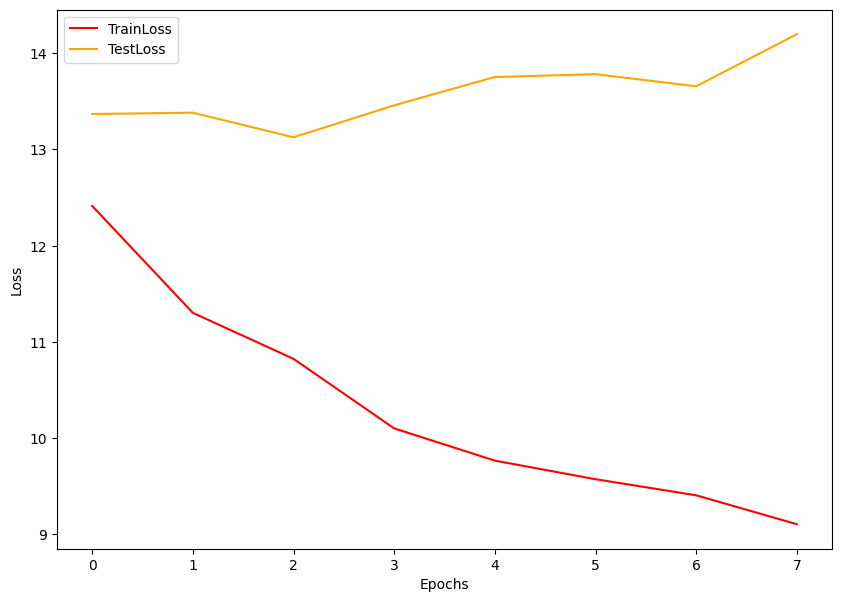

In [96]:
# 用最高測試集準確率的模型來實驗(96.189%)，調整學習率和beta1
resnet18_ = models.resnet18()
net = MyResNet()
modelname = "MyResNet_beta1"
net.load_state_dict(torch.load(os.path.join("Weights_Practice", "MyResNet_test2.pt")))  # 96.189%

trainloss, testloss = fit_test(
    net=net, 
    traindata=DataLoader(train, batch_size=256, shuffle=True, drop_last=False, pin_memory=True), 
    testdata=DataLoader(test, batch_size=256, shuffle=False, drop_last=False, pin_memory=True), 
    criterion=nn.CrossEntropyLoss(reduction="sum") , 
    optimizer=optim.Adam(net.parameters(), lr=0.0001, betas=(0.5, 0.999)), 
    epochs=30, 
    modelname=modelname, 
    PATH=r"Weights_Practice", 
    scheduler_lr_lambda=None, 
    patience=5, 
    tolerance=10**(-10), 
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    
plotloss(trainloss, testloss)

Epoch1:[7000/2197710(0%)]
Epoch1:[14000/2197710(1%)]
Epoch1:[21000/2197710(1%)]
Epoch1:[28000/2197710(1%)]
Epoch1:[35000/2197710(2%)]
Epoch1:[42000/2197710(2%)]
Epoch1:[49000/2197710(2%)]
Epoch1:[56000/2197710(3%)]
Epoch1:[63000/2197710(3%)]
Epoch1:[70000/2197710(3%)]
	 Train Loss:10.776573, Test Loss:13.258089, Train Acc:96.941%, Test Acc:96.493%
	 Weight Saved
Epoch2:[80257/2197710(4%)]
Epoch2:[87257/2197710(4%)]
Epoch2:[94257/2197710(4%)]
Epoch2:[101257/2197710(5%)]
Epoch2:[108257/2197710(5%)]
Epoch2:[115257/2197710(5%)]
Epoch2:[122257/2197710(6%)]
Epoch2:[129257/2197710(6%)]
Epoch2:[136257/2197710(6%)]
Epoch2:[143257/2197710(7%)]
	 Train Loss:10.683612, Test Loss:13.164185, Train Acc:96.965%, Test Acc:96.516%
	 Weight Saved
Epoch3:[153514/2197710(7%)]
Epoch3:[160514/2197710(7%)]
Epoch3:[167514/2197710(8%)]
Epoch3:[174514/2197710(8%)]
Epoch3:[181514/2197710(8%)]
Epoch3:[188514/2197710(9%)]
Epoch3:[195514/2197710(9%)]
Epoch3:[202514/2197710(9%)]
Epoch3:[209514/2197710(10%)]
Epoch3:[2

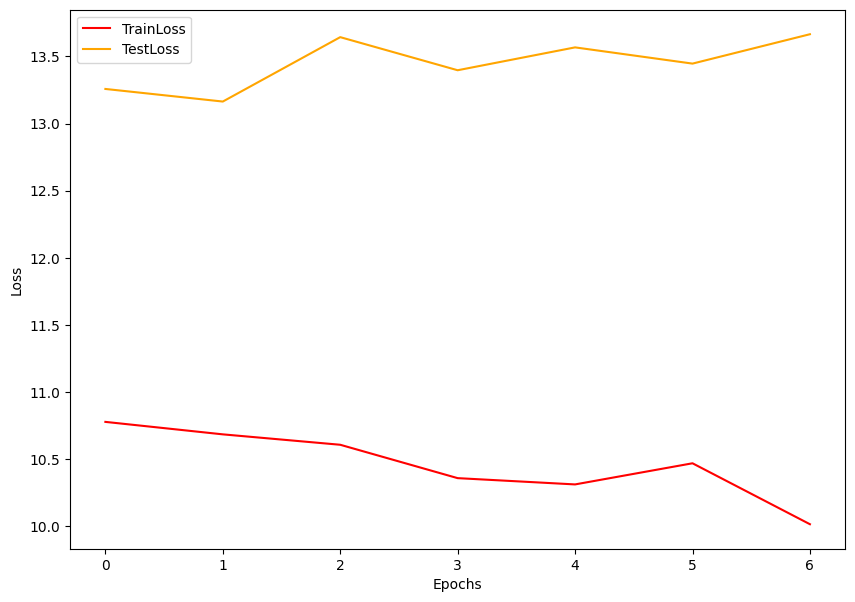

In [103]:
# 用最高測試集準確率的模型來實驗(96.535%)，調整學習率和beta1
resnet18_ = models.resnet18()
net = MyResNet()
modelname = "MyResNet_beta2"
net.load_state_dict(torch.load(os.path.join("Weights_Practice", "MyResNet_beta1.pt")))  # 96.189%

trainloss, testloss = fit_test(
    net=net, 
    traindata=DataLoader(train, batch_size=56, shuffle=True, drop_last=False, pin_memory=True), 
    testdata=DataLoader(test, batch_size=128, shuffle=False, drop_last=False, pin_memory=True), 
    criterion=nn.CrossEntropyLoss(reduction="sum"), 
    optimizer=optim.Adam(net.parameters(), lr=0.00001, betas=(0.5, 0.999)), 
    epochs=30, 
    modelname=modelname, 
    PATH=r"Weights_Practice", 
    scheduler_lr_lambda=None, 
    patience=5, 
    tolerance=10**(-10), 
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
plotloss(trainloss, testloss)

# 讀取

In [104]:
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 參考layer1刪除池化層
        # 參考ResNet設計bias設置False
        self.block1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  
                                   ,resnet18_.bn1
                                   ,resnet18_.relu) 
        
        # 小數據集先以加寬度為主非深度
        self.block2 = resnet18_.layer2 # 2個殘差單元
        self.block3 = resnet18_.layer3 # 2個殘差單元
        self.avgpool = resnet18_.avgpool
        self.fc = nn.Linear(in_features=256, out_features=10, bias=True)
    
    def forward(self,x):
        x = self.block3(self.block2(self.block1(x)))
        x = self.avgpool(x)
        x = x.view(-1, 256)
        x = self.fc(x)
        return x

In [105]:
def Initialize_Deeper_Model(pretrain=False, feature_extract=False, weight_path=None):
    resnet18_ = models.resnet18()
    net1 = MyResNet() 
    if pretrain:
        net1.load_state_dict(torch.load(weight_path))
    class MyResNet2(nn.Module):
        def __init__(self):
            super().__init__()
            # 參考layer1刪除池化層
            # 參考ResNet設計bias設置False
            self.block1 = net1.block1

            # 小數據集先以加寬度為主非深度
            self.block2 = net1.block2 # 2個殘差單元
            self.block3 = net1.block3 # 2個殘差單元
            self.block4 = resnet18_.layer4 # 多加一層增加學習能力，2個殘差單元
            self.avgpool = resnet18_.avgpool
            self.fc = nn.Linear(in_features=512, out_features=10, bias=True)

        def forward(self,x):
            x = self.block4(self.block3(self.block2(self.block1(x))))
            x = self.avgpool(x)
            x = x.view(-1, 512)
            x = self.fc(x)
            return x
        
    net2 = MyResNet2()
    if feature_extract:
        net2.block1.requires_grad_(False)
        net2.block2.requires_grad_(False)
        net2.block3.requires_grad_(False)
    return net2

In [113]:
# 定義參數
# 模型
resnet18_ = models.resnet18()
net = MyResNet()
# 數據增強
trainT = transforms.Compose([transforms.RandomCrop(28)
                             , transforms.RandomRotation(degrees=[-15, 15])
                             , transforms.ToTensor()
                             , transforms.Normalize(mean=[0.485,0.456,0.406]  # ImageNet上的均植和方差
                                                   ,std=[0.229,0.224,0.225])
                            ])
testT = transforms.Compose([transforms.CenterCrop(28)
                            , transforms.ToTensor()
                            , transforms.Normalize(mean=[0.485,0.456,0.406]  # ImageNet上的均植和方差
                                                   ,std=[0.229,0.224,0.225])
                           ])
# 數據
train = torchvision.datasets.SVHN(root='Image\datasets\SVHN'
                                 ,split="train"
                                 ,download=False
                                 ,transform=trainT
                                 )
test = torchvision.datasets.SVHN(root='Image\datasets\SVHN'
                                 ,split="test" 
                                 ,download=False
                                 ,transform=testT)

In [114]:
for modelname in ["MyResNet2_pre1", "MyResNet2_pre2", "MyResNet2_pre3"]:
    # 96.535%
    net = Initialize_Deeper_Model(pretrain=True, 
                                  feature_extract=True, 
                                  weight_path=os.path.join("Weights_Practice", "MyResNet_beta1.pt"))

    trainloss, testloss = fit_test(
        net=net, 
        traindata=DataLoader(train, batch_size=128, shuffle=True, drop_last=False, pin_memory=True), 
        testdata=DataLoader(test, batch_size=128, shuffle=False, drop_last=False, pin_memory=True), 
        criterion=nn.CrossEntropyLoss(reduction="sum") , 
        optimizer=optim.Adam(net.parameters(), lr=0.0001, betas=(0.5, 0.999)), 
        epochs=30, 
        modelname=modelname, 
        PATH=r"Weights_Practice", 
        scheduler_lr_lambda=None, 
        patience=5, 
        tolerance=10**(-10), 
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        )
    
    plotloss(trainloss, testloss)

Epoch1:[16000/2197710(1%)]
Epoch1:[32000/2197710(1%)]
Epoch1:[48000/2197710(2%)]
Epoch1:[64000/2197710(3%)]
	 Train Loss:13.033343, Test Loss:14.318251, Train Acc:96.533%, Test Acc:96.147%
	 Weight Saved
Epoch2:[89257/2197710(4%)]
Epoch2:[105257/2197710(5%)]
Epoch2:[121257/2197710(6%)]
Epoch2:[137257/2197710(6%)]
	 Train Loss:10.588237, Test Loss:13.818543, Train Acc:96.948%, Test Acc:96.374%
	 Weight Saved
Epoch3:[162514/2197710(7%)]
Epoch3:[178514/2197710(8%)]
Epoch3:[194514/2197710(9%)]
Epoch3:[210514/2197710(10%)]
	 Train Loss:10.180581, Test Loss:13.764554, Train Acc:97.024%, Test Acc:96.397%
	 Weight Saved
Epoch4:[235771/2197710(11%)]
Epoch4:[251771/2197710(11%)]
Epoch4:[267771/2197710(12%)]
Epoch4:[283771/2197710(13%)]
	 Train Loss:10.049849, Test Loss:14.225680, Train Acc:97.148%, Test Acc:96.247%
	 NOTICE: Early stopping counter 1 of 5
Epoch5:[309028/2197710(14%)]
Epoch5:[325028/2197710(15%)]
Epoch5:[341028/2197710(16%)]
Epoch5:[357028/2197710(16%)]
	 Train Loss:9.910988, Test

KeyboardInterrupt: 

In [ ]:
for modelname in ["MyResNet2_pre_1", "MyResNet2_pre_2", "MyResNet2_pre_3"]:
    # 96.535%
    net = Initialize_Deeper_Model(pretrain=True, 
                                  feature_extract=False, 
                                  weight_path=os.path.join("Weights_Practice", "MyResNet_beta1.pt"))

    trainloss, testloss = fit_test(
        net=net, 
        traindata=DataLoader(train, batch_size=256, shuffle=True, drop_last=False, pin_memory=True), 
        testdata=DataLoader(test, batch_size=256, shuffle=False, drop_last=False, pin_memory=True), 
        criterion=nn.CrossEntropyLoss(reduction="sum") , 
        optimizer=optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999)), 
        epochs=30, 
        modelname=modelname, 
        PATH=r"Weights_Practice", 
        scheduler_lr_lambda=None, 
        patience=5, 
        tolerance=10**(-10), 
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    
    plotloss(trainloss, testloss)

In [40]:
net1 = MyResNet()
net1.load_state_dict(torch.load(os.path.join("Weights_Practice", "MyResNet_test2.pt")))
net2 = MyResNet2()
net2.block1.requires_grad_(False)
net2.block2.requires_grad_(False)
net2.block3.requires_grad_(False)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1

In [39]:
net2_ = Initialize_Deeper_Model(pretrain=True, 
                                feature_extract=True, 
                                weight_path=os.path.join("Weights_Practice", "MyResNet_test2.pt"))

In [129]:
net.block3.add_module("block4", resnet18_.layer4)

In [130]:
net

MyResNet(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), 

In [111]:
[*net.parameters()][1]

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)

In [108]:
for i in net.parameters():
    print(i)

Parameter containing:
tensor([[[[-0.1256, -0.0651, -0.1012],
          [ 0.0447,  0.0826,  0.0481],
          [-0.1492,  0.0668,  0.0194]],

         [[ 0.0767, -0.0267,  0.0396],
          [-0.0701, -0.0113,  0.1136],
          [ 0.0094,  0.1118, -0.1737]],

         [[ 0.0529,  0.1506,  0.1473],
          [ 0.0692, -0.1046, -0.0478],
          [ 0.1440,  0.0522,  0.0780]]],


        [[[-0.1433,  0.1460,  0.0348],
          [-0.1222, -0.0482,  0.1015],
          [ 0.1707, -0.0450, -0.1489]],

         [[-0.0666,  0.1835,  0.1478],
          [-0.1768,  0.1492,  0.1660],
          [-0.0218,  0.1831,  0.0304]],

         [[ 0.0178, -0.0925,  0.1920],
          [ 0.1099, -0.1722, -0.0670],
          [-0.0273,  0.0164,  0.1444]]],


        [[[ 0.0152,  0.0754, -0.0420],
          [ 0.0289, -0.0398,  0.1632],
          [-0.0891,  0.1831,  0.0053]],

         [[-0.1389,  0.0144, -0.1573],
          [-0.0681, -0.0165,  0.0706],
          [-0.0520, -0.1745, -0.1623]],

         [[ 0.0591,  0

In [114]:
a = torch.load(os.path.join("Weights_Practice", "MyResNet_test2.pt"))

In [117]:
a

OrderedDict([('block1.0.weight',
              tensor([[[[-8.5268e-02, -1.6886e-01, -1.2422e-01],
                        [ 5.6351e-02, -1.6029e-01,  8.7886e-02],
                        [-5.9938e-02,  4.3274e-02,  9.9211e-02]],
              
                       [[ 2.2658e-01, -1.7535e-01, -2.6103e-03],
                        [ 2.4701e-01, -1.9115e-01, -1.1073e-01],
                        [ 2.4629e-01,  1.0399e-02,  2.3528e-02]],
              
                       [[ 6.3625e-02,  1.5651e-01,  1.0399e-02],
                        [ 7.1733e-02, -3.8747e-02,  1.7835e-02],
                        [-2.5999e-02, -4.6074e-02, -1.9392e-01]]],
              
              
                      [[[-2.1798e-02, -8.5903e-02, -2.0313e-01],
                        [-2.5528e-02,  2.1453e-01,  4.3234e-02],
                        [ 1.8673e-01, -1.5257e-02,  2.5807e-02]],
              
                       [[-1.1593e-01,  1.4863e-02,  2.4665e-02],
                        [-1.7287e-01, -9.9

In [99]:
dir(net)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_ver

In [ ]:
resnet18_ = models.resnet18()
net = MyResNet()
net.load_state_dict(torch.load(os.path.join("Weights_Practice", "MyResNet_test2.pt")))
net2 = MyResNet2()